In [6]:
import sys
sys.path.append('/usr/local/lib/python3.11/site-packages') 
import matplotlib.pylab as plt
import cartopy.crs as ccrs
import cartopy.feature as cpf
import intake
from easygems.healpix import attach_coords, healpix_show, healpix_contour
import easygems.healpix as egh
import numpy as np
import xarray as xr
import seaborn as sn
import geopy.distance
import matplotlib
import matplotlib.colors as mcolors
from matplotlib.colors import BoundaryNorm
from cartopy.io.shapereader import Reader
from matplotlib.patches import Circle
import json

from datetime import datetime


cat = intake.open_catalog("https://tcodata.mpimet.mpg.de/internal.yaml")

In [7]:
# Create a custom colormap with varying alpha
cmap = plt.cm.summer_r  # You can use any colormap
colors = cmap(np.arange(cmap.N))
alphas = np.ones(cmap.N)
alphas[0] = 0 #np.linspace(0.1, 1.0, cmap.N)
colors[:, -1] = alphas  # Set the alpha channel

# Create a new colormap with the modified alpha values
transparent_cmap = mcolors.ListedColormap(colors)

In [8]:
era5 = cat.HERA5(time="P1D").to_dask().pipe(attach_coords)
era5_hourly = cat.HERA5(time="PT1H").to_dask().pipe(attach_coords)


In [9]:
era5_hourly

<xarray.Dataset>
Dimensions:    (time: 120504, cell: 196608, level: 29, crs: 1)
Coordinates:
  * crs        (crs) float64 nan
    latitude   (cell) float32 dask.array<chunksize=(196608,), meta=np.ndarray>
  * level      (level) int64 50 70 100 125 150 175 ... 875 900 925 950 975 1000
    longitude  (cell) float32 dask.array<chunksize=(196608,), meta=np.ndarray>
  * time       (time) datetime64[ns] 2010-01-01 ... 2023-09-30T23:00:00
    lat        (cell) float64 0.2984 0.5968 0.5968 ... -0.5968 -0.5968 -0.2984
    lon        (cell) float64 45.0 45.35 44.65 45.0 ... 315.0 315.4 314.6 315.0
Dimensions without coordinates: cell
Data variables: (12/72)
    100u       (time, cell) float32 dask.array<chunksize=(24, 4096), meta=np.ndarray>
    100v       (time, cell) float32 dask.array<chunksize=(24, 4096), meta=np.ndarray>
    10u        (time, cell) float32 dask.array<chunksize=(24, 4096), meta=np.ndarray>
    10v        (time, cell) float32 dask.array<chunksize=(24, 4096), meta=np.ndarray>
    2d         (time, cell) float32 dask.array<chunksize=(24, 4096), meta=np.ndarray>
    2t         (time, cell) float32 dask.array<chunksize=(24, 4096), meta=np.ndarray>
    ...         ...
    isor       (cell) float32 dask.array<chunksize=(196608,), meta=np.ndarray>
    lsm        (cell) float32 dask.array<chunksize=(196608,), meta=np.ndarray>
    sdfor      (cell) float32 dask.array<chunksize=(196608,), meta=np.ndarray>
    sdor       (cell) float32 dask.array<chunksize=(196608,), meta=np.ndarray>
    slor       (cell) float32 dask.array<chunksize=(196608,), meta=np.ndarray>
    z_sfc      (cell) float32 dask.array<chunksize=(196608,), meta=np.ndarray>
Attributes:
    acknowledgment:  Contains modified Copernicus Climate Change Service info...
    contact:         lukas.kluft@mpimet.mpg.de
    creator:         Lukas Kluft
    description:     Selected variables from ERA5, restructured and saved on ...
    institution:     Max Planck Institute for Meteorology
    source:          Post-processed dataset based on the ERA5 mirror located ...
    title:           HERA5 - HEALPixelation of ERA5

In [10]:
era5_monthly = cat.HERA5(time="P1M").to_dask().pipe(attach_coords)

In [11]:
cwv_crit = 50.0
halo_speed_km_h = 850
EC_angle = 7.0

In [12]:
coordinates = {'mindeloNorth': 16.88, 'mindeloEast': -24.98, 
               'salNorth': 16.74, 'salEast': -22.94, 
               'bcoNorth': 13.15, 'bcoEast': -59.42,
              } 

In [13]:
ws_hourly = era5_hourly[["10u", "10v"]]
ws_hourly["ws_squared"] = ws_hourly["10u"]*ws_hourly["10u"] + ws_hourly["10v"]*ws_hourly["10v"]

dol_threshold = 3.0
ws_hourly["dol"] = xr.where((ws_hourly["ws_squared"] < dol_threshold**2) & (era5_hourly.lsm == 0), 1, 0)

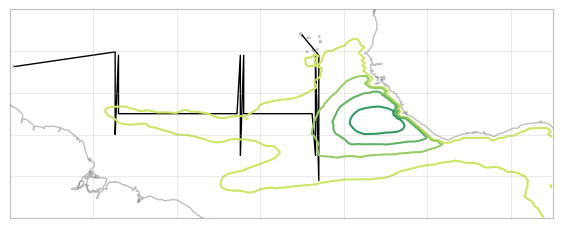

In [14]:
field = ws_hourly["dol"].sel(time='2020').mean("time") 

plt.figure(figsize = (7, 4))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_extent([-60, 5, -5, 20], crs=ccrs.PlateCarree())
ax.coastlines(alpha=0.25)
ax.gridlines(draw_labels=False, dms=True, x_inline=False, y_inline=False, alpha = 0.25)

# Load the dictionary from the JSON file
with open('../TrackPlanning/track.json', 'r') as json_file:
    track_dic = json.load(json_file)

# Plot ship track
p1 = plt.plot(track_dic['track_lon'], track_dic['track_lat'], alpha=1.0, color = 'k', linewidth = 1)

im = healpix_contour(field, method="linear", cmap = transparent_cmap, levels = 4, vmin = 0.0, linewidths = 1.5)

# Set the edge color and transparency (alpha) of the axes
for spine in ax.spines.values():
    spine.set_edgecolor('k')
    spine.set_alpha(0.25)

plt.savefig('test.png', transparent=True, bbox_inches = "tight")